In [171]:
def mean_absolute_percentage_error(y_true, y_pred, df):
    df = df[(df["env_slopesolar"] != 0 ) & ( df["env_levelsolar"] != 0 ) & ( df["match_solar"] != 0 )]

    a_set, b_set = np.array(df[y_true]), np.array(df[y_pred])

    print(y_true, ", ", y_pred, " MAPE : ", np.mean(np.abs((a_set - b_set) / a_set)) * 100)


def make_graph(a, b, df):
    df = df[df[a] != 0]
    df = df[df[b] != 0]

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(x=df.index, y=df[a], mode='lines', name="기업 일사량", line=dict(color='blue')), secondary_y = False)
    fig.add_trace(go.Scatter(x=df.index, y=df[b], mode='lines', name="기상청 일사량", line=dict(color='red')), secondary_y = False)
    fig.update_layout(width=800, height=300,)
    fig.show()


def group_reset(df):
    df_group = df.groupby("datemonth").mean().reset_index()
    mean_list = []
    month_list = []

    for i in range(len(df_group)):
        mean_set = df_group["env_slopesolar"][i] / df_group["match_solar"][i] 
        mean_list.append(mean_set)
        month_list.append(df_group["datemonth"][i])

    df["reset_match"] = 0.000
    for i in range(len(df)):
        for j, k in zip(mean_list, month_list):
            if df["datemonth"][i] == k:
                df["reset_match"][i] = df["match_solar"][i] * j
            else:
                pass
    
    return df

def split_month(df):
    datemonth_list = []

    for i in df.env_date:
        datemonth_list.append(i[5:7])
    
    df["datemonth"] = datemonth_list

    return df

def diff_12(df):
    df["diff"] = df["env_slopesolar"] - df["match_solar"]

    
    # print(np.quantile(df["diff1"], 0.9))

    return df[(df["diff"] < np.quantile(df["diff"], 0.9)) & (df["diff"] > np.quantile(df["diff"], 0.1))]

def split_datetime(df):
    a = df[df["dummy_time"] == "09"]
    b = df[df["dummy_time"] == "10"]
    c = df[df["dummy_time"] == "11"]
    d = df[df["dummy_time"] == "12"]
    e = df[df["dummy_time"] == "13"]
    f = df[df["dummy_time"] == "14"]
    g = df[df["dummy_time"] == "15"]
    h = df[df["dummy_time"] == "16"]
    i = df[df["dummy_time"] == "17"]

    return a, b, c, d, e, f, g, h, i 

def diff1_plotly():
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(x=a.index, y=a["diff"], mode='lines', name="09시", line=dict(color='aqua')), secondary_y = False)
    # fig.add_trace(go.Scatter(x=a.index, y=b["diff1"], mode='lines', name="b", line=dict(color='black')), secondary_y = False)
    # fig.add_trace(go.Scatter(x=a.index, y=c["diff1"], mode='lines', name="c", line=dict(color='brown')), secondary_y = False)
    # fig.add_trace(go.Scatter(x=a.index, y=d["diff1"], mode='lines', name="d", line=dict(color='blue')), secondary_y = False)
    fig.add_trace(go.Scatter(x=a.index, y=e["diff"], mode='lines', name="13시", line=dict(color='coral')), secondary_y = False)
    # fig.add_trace(go.Scatter(x=a.index, y=f["diff1"], mode='lines', name="f", line=dict(color='gold')), secondary_y = False)
    # fig.add_trace(go.Scatter(x=a.index, y=g["diff1"], mode='lines', name="g", line=dict(color='red')), secondary_y = False)
    # fig.add_trace(go.Scatter(x=a.index, y=h["diff1"], mode='lines', name="h", line=dict(color='orange')), secondary_y = False)
    fig.add_trace(go.Scatter(x=a.index, y=i["diff"], mode='lines', name="17시", line=dict(color='green')), secondary_y = False)
    # fig.add_trace(go.Scatter(x=to_day_sum.index, y=to_day_sum["match_solar"], mode='lines', name="기상청", line=dict(color='red')), secondary_y = True)
    fig.update_layout(width=500, height=300,)
    fig.show()
    print("경사면일사량 - 기상청일사량")
    print("09시 : ", np.round(a["diff"].mean(), 2), " - 13시 : ", np.round(e["diff"].mean(), 2), " - 17시 : ", np.round(i["diff"].mean(), 2))

def boxplot():
    fd, axes = plt.subplots(3, 3, figsize=(12, 5))
    
    sns.boxplot(data = a[["env_slopesolar", "match_solar"]], ax=axes[0][0])
    sns.boxplot(data = b[["env_slopesolar", "match_solar"]], ax=axes[0][1])
    sns.boxplot(data = c[["env_slopesolar", "match_solar"]], ax=axes[0][2])
    sns.boxplot(data = d[["env_slopesolar", "match_solar"]], ax=axes[1][0])
    sns.boxplot(data = e[["env_slopesolar", "match_solar"]], ax=axes[1][1])
    sns.boxplot(data = f[["env_slopesolar", "match_solar"]], ax=axes[1][2])
    sns.boxplot(data = g[["env_slopesolar", "match_solar"]], ax=axes[2][0])
    sns.boxplot(data = h[["env_slopesolar", "match_solar"]], ax=axes[2][1])
    sns.boxplot(data = i[["env_slopesolar", "match_solar"]], ax=axes[2][2])

def boxplot1():
    fd, axes = plt.subplots(3, 3, figsize=(12, 5))
    
    sns.boxplot(data = a[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[0][0])
    sns.boxplot(data = b[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[0][1])
    sns.boxplot(data = c[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[0][2])
    sns.boxplot(data = d[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[1][0])
    sns.boxplot(data = e[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[1][1])
    sns.boxplot(data = f[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[1][2])
    sns.boxplot(data = g[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[2][0])
    sns.boxplot(data = h[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[2][1])
    sns.boxplot(data = i[["env_slopesolar", "match_solar", "reset_match"]], ax=axes[2][2])

def match_power_weather(power_data, weather_data):
    power_weather=[]
    for i in power_data.index:
        date_time = str(i).split(" ")
        date_time_df = weather_data[weather_data['일시']==date_time[0]]
        sub = list(date_time_df.iloc[0,3:])
        sub+=list(power_data[power_data.index==date_time[0]].iloc[0,:])
        power_weather.append(sub)
    
    return power_weather

# Enitt Proj
## 기상청 일기예보 정보를 통한 발전소별 발전량 예측

    
    1. Project intro
    2. Enterprise data set
    3. data preprocessing 
    4. Exploratory data analysis
    5. data crawling
    6. data preprocessing, make data set 
    7. modeling and training
    8. validation, evaluation
    

### 0. load module

In [126]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import datetime
import seaborn as sns 
import scipy.stats
import plotly.express as px
from scipy import stats

### 1. Project intro

##### 기상청 일기예보 정보를 통한 발전소별 태양광 발전량을 예측한다.
##### 현재 https://bd.kma.go.kr/kma2020/fs/energySelect1.do?pageNum=5&menuCd=F050701000 처럼
##### 각 지역에 맞는 일사량에 따른 발전량 예측사이트가 있지만, 
##### 태양광 발전량은 주변 지역 환경과 설비용량, 각 인버터 스펙에 따른 민감도가 존재한다. 즉 대략적인 발전량 예측은 가능하지만 설비용량과 출력스펙을 고려한 발전량은 예측이 불가능하다.
##### 이 프로젝트에서는 Enitt 발전소별 일사량 보정값과 가장 인접해 있는 지역의 환경데이터를 통하여 
##### 각 발전소별 모델링을 구축하여 발전소 맞춤형 태양광 발전량 예측 모델을 설계한다.

### 2. Enterprise data set


##### 각 지역별 발전량 정보 및 환경센서 정보


In [127]:
ent_data_solar_반포 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/365. 반포써밋2블럭 발전량.csv", encoding="ms949")
ent_data_solar_반포2 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/A365. 반포써밋2블럭 발전량.csv", encoding="ms949")

ent_data_solar_전북대= pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/463. 전북대NewREC 발전량.csv", encoding="ms949")
ent_data_weather1 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/365. 반포써밋2블럭 환경정보.csv", encoding="ms949")
ent_data_weather2 = pd.read_csv("./ENITT_SOLAR_DATA/ENITT_SOLAR_DATA/A365. 반포써밋2블럭 환경센서.csv", encoding="ms949")

ent_data_solar_반포 = pd.concat([ent_data_solar_반포, ent_data_solar_반포2])
ent_data_weather1 = pd.concat([ent_data_weather1, ent_data_weather2])
ent_data_solar1 = ent_data_solar_반포[ent_data_solar_반포["pow_id"]==1]

watt_1 = ent_data_solar1
watt_2 = ent_data_solar_전북대

POW_CAP = 20.0

ent_data_solar1.head(5)


,pow_index,pow_id,pow_date,pow_time,pow_cap,pow_dcv,pow_dca,pow_dcp,pow_acvr,pow_acvs,pow_acvt,pow_acar,pow_acas,pow_acat,pow_acp,pow_pf,pow_totpower,pow_freq
10,11,1,2018-10-18,14:44:17,20.0,507,19.7,9900.0,378,375,377,14.9,15.9,15.6,9500.0,0.9,2936000,60.0
175,176,1,2018-10-18,17:43:13,20.0,418,0.0,0.0,377,376,377,1.5,1.6,1.7,0.0,0.0,2944000,59.9
176,177,1,2018-10-18,17:44:06,20.0,442,0.0,0.0,377,376,376,1.4,1.5,1.5,0.0,0.0,2944000,60.0
177,178,1,2018-10-18,17:49:34,20.0,442,0.0,0.0,378,376,377,1.5,1.6,1.6,0.0,0.0,2944000,60.0
178,179,1,2018-10-18,17:50:27,20.0,425,0.0,0.0,377,375,377,1.6,1.6,1.6,0.0,0.0,2944000,59.9


In [128]:
ent_data_solar1.head(5)

,pow_index,pow_id,pow_date,pow_time,pow_cap,pow_dcv,pow_dca,pow_dcp,pow_acvr,pow_acvs,pow_acvt,pow_acar,pow_acas,pow_acat,pow_acp,pow_pf,pow_totpower,pow_freq
10,11,1,2018-10-18,14:44:17,20.0,507,19.7,9900.0,378,375,377,14.9,15.9,15.6,9500.0,0.9,2936000,60.0
175,176,1,2018-10-18,17:43:13,20.0,418,0.0,0.0,377,376,377,1.5,1.6,1.7,0.0,0.0,2944000,59.9
176,177,1,2018-10-18,17:44:06,20.0,442,0.0,0.0,377,376,376,1.4,1.5,1.5,0.0,0.0,2944000,60.0
177,178,1,2018-10-18,17:49:34,20.0,442,0.0,0.0,378,376,377,1.5,1.6,1.6,0.0,0.0,2944000,60.0
178,179,1,2018-10-18,17:50:27,20.0,425,0.0,0.0,377,375,377,1.6,1.6,1.6,0.0,0.0,2944000,59.9


In [129]:
ent_data_weather1.head(5)

,env_index,env_date,env_time,env_slopesolar,env_levelsolar,env_modtemp,env_airtemp
0,1,2018-10-22,12:44:29,322,316,24.8,17.6
1,2,2018-10-22,12:45:21,320,314,25.0,17.7
2,3,2018-10-22,12:46:12,320,312,25.1,17.9
3,4,2018-10-22,12:47:04,326,319,24.9,18.1
4,5,2018-10-22,12:47:56,335,329,24.9,18.0


### 3. data preprocessing
    1) 필요 파라미터 선별
    2) 비정상데이터 처리 ( 보듬이나눔이 )
    3) 초단위 -> 시간단위
    4) 발전량 + 환경센서(일사량)  
    5) 예측 시간 설정
    6) watt(발전량) / pow_cap(설비용량) => 1kW 설비용량일 때의 발전량


    1) 필요 파라미터 선별 : 발전량 데이터에서 시간, 누적발전량


In [130]:
ent_data_solar1_need = ent_data_solar1[["pow_date", "pow_time","pow_cap", "pow_totpower"]]
ent_data_weather1_need = ent_data_weather1[["env_date", "env_time", "env_slopesolar", "env_levelsolar"]]

    2) 비정상데이터 처리 : 보듬이나눔이 환경센서 일사량 데이터가 다른 발전소의 일사량에 비해 비 정상적으로 낮어 사용 x


    3) 초 단위 -> 시간 단위 : 사용할 기상청 환경데이터의 최소단위가 1시간이라 1시간 단위로 설정
    => pow_totpower : 시간으로 묶고 처음과 끝을 빼서 계산
    => env_slopesolar, env_levelsolar : 시간으로 묶고 평균으로 계산

In [132]:
# def make_date(df):
def solar_make_dummy_time(df):
    time_list = []
    for i in df["pow_time"]:
        time_list.append(i[:2])
    df["dummy_time"] = time_list

    return df

def weather_make_dummy_time(df):
    time_list = []
    for i in df["env_time"]:
        time_list.append(i[:2])
    df["dummy_time"] = time_list

    return df

def groupby_min(df):
    return df.groupby(["pow_date", "dummy_time"]).min()

def groupby_max(df):
    return df.groupby(["pow_date", "dummy_time"]).max()

def groupby_mean0(df):
    return df.groupby(["env_date", "dummy_time"]).mean()

def groupby_mean(df):
    return df.groupby(["pow_date", "dummy_time"]).mean()

def sub(df1, df2):
    dummy = df1["pow_totpower"] - df2["pow_totpower"]
    df1["hour_power"] = dummy
    return df1[["hour_power"]]
# groupby_min(make_dummy_time(ent_data_solar1_need))
# groupby_max(make_dummy_time(ent_data_solar1_need))

In [133]:
ent_data_solar1_hour = sub(
        groupby_max(solar_make_dummy_time(ent_data_solar1_need)), 
        groupby_min(solar_make_dummy_time(ent_data_solar1_need))
        ).reset_index()

ent_data_weather1_hour = groupby_mean0(weather_make_dummy_time(ent_data_weather1_need)).reset_index()
ent_data_weather1_hour.head(5)

,env_date,dummy_time,env_slopesolar,env_levelsolar
0,2018-10-22,12,333.375000,321.937500
1,2018-10-22,13,490.514286,563.442857
2,2018-10-22,14,368.214286,426.042857
3,2018-10-22,15,242.214286,294.400000
4,2018-10-22,16,116.159420,132.362319


In [134]:
ent_data_solar1_hour.head(10)

,pow_date,dummy_time,hour_power
0,2018-10-18,14,0
1,2018-10-18,17,0
2,2018-10-18,18,0
3,2018-10-19,06,0
4,2018-10-19,07,0
5,2018-10-19,08,0
6,2018-10-19,10,4000
7,2018-10-19,11,9000
8,2018-10-19,12,9000
9,2018-10-19,13,10000



    pow_totpower 로 시간을 나누었더니 결과값이 이상하게 나옴

    -> pow_totpower의 최소측정단위가 1000W여서 발전량이 있더라도 1000W를 넘기지 못하면 모두 0 으로 표시가 되는 현상때문

      EDA. 발전량(energy generation)
       : 전류 x 전압 = 에너지 
       
       * 발전량 정보 데이터의 pow_dcp, pow_totpower 컬럼이 에너지를 나타내는 부분이나, 센서의 민감도나 측정단위 문제로 정확한 측정이 안된다.
         pow_dcp의 측정 최소 단위는 100W이고 pow_totpower의 측정 최소단위는 1000W이고 
         pow_dcp는 149W까지는 측정이 불가하고 150W부터 반내림한 100W로 측정을 하게 된다 (pow_totpower 이와 동일)

         하여 정확한 발전량 측정을 하기 위하여 직류전류(pow_dcv) X 직류전압(pow_dca) 를 발전량 칼럼인 Watt로 생성하였다.
         

In [135]:
ent_data_solar1_need = ent_data_solar1[["pow_date","pow_time","pow_cap", "pow_dcv", "pow_dca"]]



print("전력", ent_data_solar1["pow_dcp"].unique()[:5])
print("누적발전량", ent_data_solar1["pow_totpower"].unique()[:5])
print("전력, 누적발전량의 측정최소단위가 정해져 있다. -> 전류 * 전압으로 발전량 watt 설정")

def make_generation(df):
    df["watt"] = df["pow_dcv"] * df["pow_dca"]

    return df

ent_data_solar1_watt = make_generation(ent_data_solar1_need)
ent_data_solar1_hour =  groupby_mean(solar_make_dummy_time(ent_data_solar1_watt)).reset_index()


전력 [9900.    0.  100.  200.  500.]
누적발전량 [2936000 2944000 2958000 2959000 2960000]
전력, 누적발전량의 측정최소단위가 정해져 있다. -> 전류 x 전압으로 발전량 watt 설정


    4) 발전량 + 환경센서

In [136]:
def join_weather_solar(a, b):
    sub_index1 = a["env_date"] + " " + a["dummy_time"] + ":00"
    a.index = sub_index1

    sub_index2 = b["pow_date"] + " " + b["dummy_time"] + ":00"
    b.index = sub_index2

    joinset = a.join(b[["watt"]])
    ent_data_solar_weather = joinset.dropna()


    return ent_data_solar_weather

ent_data_solar_weather = join_weather_solar(ent_data_weather1_hour, ent_data_solar1_hour)
ent_data_solar_weather.head(5)





,env_date,dummy_time,env_slopesolar,env_levelsolar,watt
2018-10-22 12:00,2018-10-22,12,333.375000,321.937500,5536.874419
2018-10-22 13:00,2018-10-22,13,490.514286,563.442857,6808.306122
2018-10-22 14:00,2018-10-22,14,368.214286,426.042857,5217.690909
2018-10-22 15:00,2018-10-22,15,242.214286,294.400000,3306.254098
2018-10-22 16:00,2018-10-22,16,116.159420,132.362319,1589.776190


In [137]:
drop_data = ent_data_solar_weather.isin({"dummy_time" : ["00", "01", "02", "03", "04", "05", "06", "07","08","18", "19", "20", "21", "22", "23"]})
ent_data_perhour_sort = ent_data_solar_weather[~drop_data].dropna()
ent_data_perhour_sort.dummy_time.unique()

array(['12', '13', '14', '15', '16', '17', '09', '10', '11'], dtype=object)

    실질적으로 발전되는 09~17시의 발전량 데이터를 가져옴 

    6) watt / pow_cap : 설비용량에 따라 발전량이 다르기 때문에 설비용량을 1kW 초기셋팅 한다.

     설비용량(pow_cap)
       : 설비용량에 따라 에너지 생산량이 변함. ( 태양광 발전기 크기와 비슷하게 이해해도 무방함 )
         에너지생산량은 설비용량에 비례한다. 

In [139]:
watt_1["watt"] = watt_1["pow_dcv"] * watt_1["pow_dca"]
watt_2["watt"] = watt_2["pow_dcv"] * watt_2["pow_dca"]
print(
    "설비용량 20kW : ", 
    watt_1[watt_1["pow_cap"] == 20.0].describe()["watt"][1], 
    "---------",
    "설비용량 3kW : ",
    watt_2[watt_2["pow_cap"] == 3.0].describe()["watt"][1])

설비용량 20kW :  4604.847189810905 --------- 설비용량 3kW :  777.4127843916241


In [140]:
ent_data_perhour_sort['watt'] = ent_data_perhour_sort['watt'] / POW_CAP

### 4. Exploratory Data Analysis (EDA)

    1) 기업데이터의 발전량과 기업의 환경센서 상관관계

In [141]:
ent_data_perhour_sort.corr()

,env_slopesolar,env_levelsolar,watt
env_slopesolar,1.000000,0.915188,0.980203
env_levelsolar,0.915188,1.000000,0.865496
watt,0.980203,0.865496,1.000000


    => 일사량과 0.98, 0.86 큰 상관관계가 있음, 경사면 일사량과 수평면 일사량 중 상관관계가 더 큰 경사면 일사량을 사용
    

    2) 기업데이터 일사량과 기상청 일사량의 Mean_absolute_percentage_error
    
     : 일사량은 발전량과 가장 큰 상관관계를 보인다. 
     : 기상청의 일사량 + 환경데이터 를 통해 발전량을 예측하기 위해선 "기상청의 환경데이터" 와 "기업데이터의 환경데이터" 가 유사하다는 가정이 있어야 한다.
     : 발전량과 가장 큰 상관관계를 보이는 일사량의 유사도를 확인하기 위해 MAPE를 구하고 낮춰가는 방향으로 EDA 진행
     : MAPE가 낮으면 기업의 일사량을 기상청의 일사량으로 대체하여 결과를 예측가능하다.
     
    

    비교하기 위한 DataFrame 생성 ( 기업데이터 + 환경데이터 데이터프레임 생성 )

env_slopesolar ,  match_solar  MAPE :  300.88748861029495


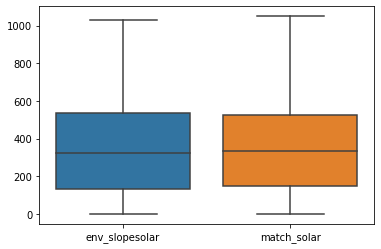

In [142]:
other_weather_dummy1 = pd.read_csv("./ENITT_SOLAR_DATA/re_allweather/allweather2018.csv", encoding="ms949")
other_weather_dummy2 = pd.read_csv("./ENITT_SOLAR_DATA/re_allweather/allweather2019.csv", encoding="ms949")
other_weather_dummy3 = pd.read_csv("./ENITT_SOLAR_DATA/re_allweather/allweather2020.csv", encoding="ms949")

other_data_weather =  other_weather_dummy1.merge(other_weather_dummy2, how="outer").merge(other_weather_dummy3, how="outer")
other_data_weather = other_data_weather[other_data_weather["지점명"] == "서울"][["일시", "일사(MJ/m2)"]].fillna(0)
other_data_weather = other_data_weather.set_index("일시")

ent_other_joinset = ent_data_perhour_sort.join(other_data_weather["일사(MJ/m2)"])
ent_other_joinset

## MJ/m2 -> W/m2 으로 단위 변환 ( 일사 -> match_solar )
ent_other_joinset["match_solar"] = ent_other_joinset["일사(MJ/m2)"] * 1000000 / 3600
ent_other_joinset

sns.boxplot(data = ent_other_joinset[["env_slopesolar", "match_solar"]])

mean_absolute_percentage_error("env_slopesolar", "match_solar", ent_other_joinset)

In [165]:
print(ent_other_joinset.corr()[:1]["match_solar"])
make_graph("env_slopesolar", "match_solar", ent_other_joinset[500:600])

env_slopesolar    0.854033
Name: match_solar, dtype: float64


    : 기업 일사량과 기상청 일사량 같은 단위로 변환
    : 같은 시간 대 기업의 일사량과 기상청의 일사량이 평균적으로 차이가 있어서 상관관계는 0.85로 높게 나오지만 MAPE 또한 높게 나옴
    => 기업 일사량과 기상청 일사량이 비슷한 range 안에 있지만 MAPE가 매우 높다. 

    MAPE가 높은 원인 

    1) 센서의 민감도 : 기상청에서 사용한 센서와 기업에서 사용한 센서의 민감도 차이에 의한 일사량 차이 추측
    / 일사량이 높을 때와 낮을 때 차이 비교
    2) 경사각과 해의 위치 : 시간에 따른 해 위치에 따라 기업과 기상청에서 측정한 일사량 간 차이가 생길 것이라 추측
    / 시간 별 일사량의 차이를 확인 비교
    3) outlier



    해결방안 
    
    1) 일사량을 하루단위로 묶어 계산.
    2) 기상청 일사량을 각 발전소의 시간별 조정값을 두어 조정된 값을 사용한다. 
    3) outlier 제거
    

    => MAPE를 줄이기 위해 시간단위가 아닌 먼저 일 단위로 묶어서 계산

env_slopesolar ,  match_solar  MAPE :  8.996206896186404


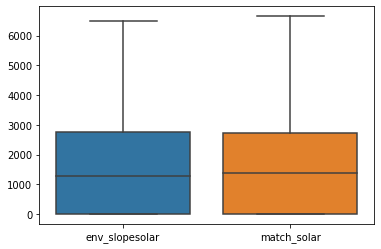

In [144]:
# to_day_need = ent_other_joinset[["env_slopesolar", "match_solar", "watt"]].resample('D').sum()
# to_day_sum = to_day_need.resample('D').sum()
date_list = pd.to_datetime(ent_other_joinset.index)
to_day_need = ent_other_joinset[["env_slopesolar", "match_solar","env_levelsolar", "watt"]]
to_day_need.index = date_list
to_day_need = diff_12(to_day_need) # outlier 제거
to_day_need = to_day_need.resample('D').sum()

sns.boxplot(data = to_day_need[["env_slopesolar", "match_solar"]])
mean_absolute_percentage_error("env_slopesolar", "match_solar", to_day_need)



In [164]:
print(to_day_need.corr()[:1]["match_solar"])
make_graph("env_slopesolar", "match_solar", to_day_need[:100])

env_slopesolar    0.995936
Name: match_solar, dtype: float64


    일 단위로 묶었을 경우 MAPE가 300에서 8.99으로 확연히 감소하는 걸 볼 수 있다. 
    
    => 각 시간별 일사량의 차이를 통해 또 다른 개선점을 찾아본다.

In [146]:
ent_other_joinset["diff"] = ent_other_joinset["env_slopesolar"] - ent_other_joinset["match_solar"]

In [167]:
test_diff = ent_other_joinset[:700]

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=test_diff.index, y=test_diff["diff"], mode='lines', name="diff", line=dict(color='blue')), secondary_y = False)
fig.update_layout(width=800, height=400,)
fig.show()


        시간 단위로 나누어 기업의 일사량과 기상청의 일사량의 차이를 시각화 해보니 일정한 패턴이 있다.
        
        => 기업의 일사량은 시간 즉 해의 위치에 민감하게 반응을 하는데 비해 기상청의 일사량은 그렇지 않다
           여기서 나오는 차이로 인하여 전체 MAPE가 높아진다.

        => 해의 위치(시간)와 계절(=월 별)(계절에 따라 일출 일몰 시간이 달라짐)에 따라 보정값을 준다.(match_solar -> reset_match)

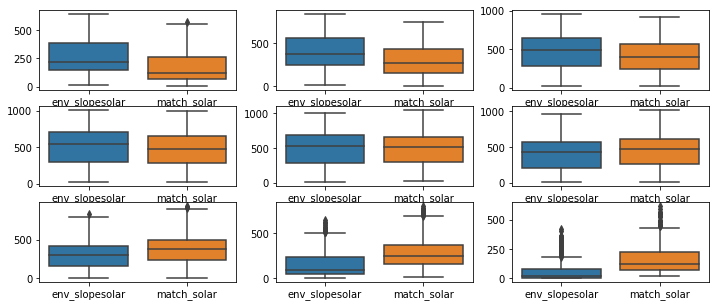

In [148]:
ent_other_joinset

ent_other_joinset_month = split_month(ent_other_joinset) ## 월 별 칼럼 추가
ent_other_joinset_reset = group_reset(ent_other_joinset_month)
a, b, c, d, e, f, g, h, i = split_datetime(ent_other_joinset_reset) ## 시간 별 나눔
ent_other_joinset

ent_other_joinset_month = split_month(ent_other_joinset) ## 월 별 칼럼 추가
ent_other_joinset_reset = group_reset(ent_other_joinset_month)
a, b, c, d, e, f, g, h, i = split_datetime(ent_other_joinset_reset) ## 시간 별 나눔
a, b, c, d, e, f, g, h, i = diff_12(a), diff_12(b), diff_12(c), diff_12(d), diff_12(e), diff_12(f), diff_12(g), diff_12(h), diff_12(i) ## outlier 제거


boxplot()

In [149]:
diff1_plotly() ## 밝은 날만 가져와서,,

경사면일사량 - 기상청일사량
09시 :  88.97  - 13시 :  4.65  - 17시 :  -99.86


        대부분 시간대에서 09시에는 기업 일사량이 높아지고 , 17시에는 기상청 일사량이 높아지는 것을 확인할 수 있다.

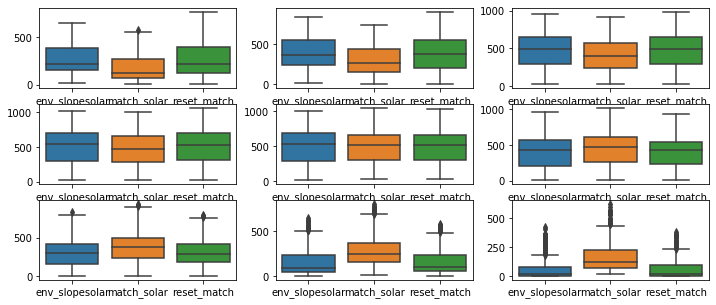

In [172]:
a, b, c, d, e, f, g, h, i = group_reset(a), group_reset(b), group_reset(c), group_reset(d), group_reset(e), group_reset(f), group_reset(g), group_reset(h), group_reset(i)

boxplot1()

    기업데이터 일사량과, 발전소 별, 시간 별 보정치를 추가한 reset_match 
    
    기업데이터 일사량과 보정치를 추가한 reset_match MAPE

In [151]:
reset_match_all = pd.concat([a, b, c, d, e, f, g, h, i])
mean_absolute_percentage_error("env_slopesolar", "reset_match", reset_match_all)
# reset_match_all

env_slopesolar ,  reset_match  MAPE :  30.379033784826298



    reset_match 전 보다 5배가량 MAPE 감소 확인 ( 300 -> 30 )
    => reset_match 한 데이터를 일 별로 묶어 가장 이상적인 환경의 데이터 셋 확보

In [173]:
# reset_match_all_day = reset_match_all.resample('D').sum()
date_list = pd.to_datetime(reset_match_all.index)
reset_match_to_day = reset_match_all[["env_slopesolar","env_levelsolar","match_solar", "reset_match", "watt"]]
reset_match_to_day.index = date_list

reset_match_to_day = reset_match_to_day.resample('D').sum()

reset_match_to_day
mean_absolute_percentage_error("env_slopesolar", "reset_match", reset_match_to_day) 
reset_match_to_day.head(5) 

env_slopesolar ,  reset_match  MAPE :  7.1951303768820445


,env_slopesolar,env_levelsolar,match_solar,reset_match,watt
2018-10-22,1241.406625,1441.465424,1655.555556,1343.782008,863.328033
2018-10-23,1878.443064,2288.875569,1952.777778,1748.395500,1370.786517
2018-10-24,504.979266,909.124224,977.777778,587.399248,304.525439
2018-10-25,2963.771843,3909.373706,2891.666667,2759.806976,2125.209641
2018-10-26,272.495031,267.882402,530.555556,331.631734,202.993101


        보정치를 준 reset_match 와 env_slopesolar를 일 단위로 묶어서 MAPE를 계산,  7.19 결과를 얻음

        즉 보정치를 통하여 경사각에 따른 일사량 차이와 각 발전소 센서의 민감도에 따른 일사량 차이를 함께 완화 시킬 수 있다.
        
        banpo1  -  env_slopesolar , reset_match  :  7.1951303768820445
        newrec1  -  env_slopesolar , reset_match  :  18.005411740639172
        lh  -  env_slopesolar , reset_match  :  8.849778164945214
        ongok  -  env_slopesolar , reset_match  :  11.82214185728767

        banpo1  -  env_slopesolar , match_solar  :  9.295852296152567
        newrec1  -  env_slopesolar , match_solar  :  20.575481219383054
        lh  -  env_slopesolar , match_solar  :  24.56966448174712
        ongok  -  env_slopesolar , match_solar  :  38.63580674696487

        => 각 데이터의 MAPE


        이후 모델링 훈련 후 내일 기상예보에 관한 예측을 할 때 
        기상청의 일사량 데이터(일조(MJ/m2)를 단위변환 후(Match_solar) 보정치를 주어(reset_match) 보정된 값으로 발전량 예측

### 5. Data crawling

1) 목적 :
- 기업 발전량 데이터와 기상청 날씨 데이터를 결합하여 날씨데이터 기반으로 발전량 예측하기 위한 데이터 크롤링
- 공공데이터를 통하여 최대한 기업과 인접한 지역의 날씨데이터와 결합


2) 데이터 : 
 - 기상청 날씨 데이터 컬럼
 
        "최저기온(°C)"
        "최고기온(°C)"
        "일강수량(mm)"
        "평균 풍속(m/s)"
        "평균 상대습도(%)"
        "가조시간(hr)" : 태양이 떠있는 시간 -> 계절에 따라 달라지기 때문에 계절성을 반영하기 위해 추가
        "평균 전운량(1/10)" : 하늘을 덮고 있는 구름의 양의 비율 1~10까지 numeric 형태로 기록 
        "평균 일사량(MJ/m^2) : 기업데이터의 W/m^2 형태로 변환하기 위하여 10^6 / 3600 로 단위 변환 -> match_solar 로 컬럼명 지정
      
- 출처 : https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36


3) 예측 데이터
 - 기상청 날씨데이터 사용
 
       :  https://www.weather.com/ko-KR/weather/today
       :  https://www.weather.go.kr

 - 각 지역별 예측 발전량 사용
 
       :  https://bd.kma.go.kr/kma2020/svc/main.do


### 6. data preprocessing, make data set 
    - 기업데이터에 인접한 지역의 기상데이터를 가져와 데이터셋 만듬




In [153]:
total_weather = pd.read_csv("./마지막데이터/allweather.csv", encoding="ms949") ## 2018~2020년 데이터
banpo1_weather = total_weather[total_weather['지점명']=='서울'] ## 반포 인접지역인 서울 기상데이터 선택
banpo1_weather

banpo1_power_weather = match_power_weather(reset_match_to_day, banpo1_weather)
banpo1_power_weather_df = pd.DataFrame(data = banpo1_power_weather, columns=[
    '최저기온', '최고기온', '일강수량', '평균 풍속',
    '평균 상대습도', '가조시간', '합계일사량', '평균 전운량','env_slopesolar', 'env_levelsolar', 'match_solar',
    'reset_match',
    'watt'])
banpo1_power_weather_df_need =banpo1_power_weather_df[[
    '최저기온', '최고기온', '일강수량', '평균 풍속', '평균 상대습도', '가조시간', '평균 전운량','env_slopesolar', 'match_solar',
    'reset_match', 'watt']] ## 필요한 column 선택
banpo1_power_weather_df_need.fillna(0, inplace=True) # 강수량 NaN -> 0

banpo1_power_weather_df_need.head(5)

,최저기온,최고기온,일강수량,평균 풍속,평균 상대습도,가조시간,평균 전운량,env_slopesolar,match_solar,reset_match,watt
0,8.8,20.6,0.0,1.0,50.0,11.0,5.3,1241.406625,1655.555556,1343.782008,863.328033
1,9.8,16.9,5.0,1.1,75.1,11.0,5.4,1878.443064,1952.777778,1748.395500,1370.786517
2,7.6,18.7,0.0,1.3,66.0,10.9,0.5,504.979266,977.777778,587.399248,304.525439
3,7.0,21.2,0.0,0.9,55.5,10.9,4.0,2963.771843,2891.666667,2759.806976,2125.209641
4,9.9,14.7,11.0,1.6,74.1,10.8,7.5,272.495031,530.555556,331.631734,202.993101


### 7. modeling, training
    - 위와 같이 전처리 후 합쳐서 한 개의 csv로 처리했음


In [186]:
all_data = pd.read_csv('./마지막데이터/total_enitt_data2.csv', encoding='utf-8')
all_data.drop(["Unnamed: 0", '합계 일사량(MJ/m2)', "env_levelsolar", "match_solar"], axis=1, inplace=True)
all_data.columns = ["최저기온", "최고기온", "일강수량", "평균풍속", "평균상대습도", "가조시간", "평균전운량", "env_slopesolar", "reset_match", "watt"]
all_data.fillna(0, inplace=True)

data1 = all_data[["env_slopesolar", "watt"]]
data2 = all_data[["reset_match", "watt"]]
data3 = all_data[["최저기온", "최고기온", "일강수량", "평균풍속", "평균상대습도", "가조시간", "평균전운량", "env_slopesolar", "watt"]]
data4 = all_data[["최저기온", "최고기온", "일강수량", "평균풍속", "평균상대습도", "가조시간", "평균전운량", "reset_match", "watt"]]





7. modeling and training
- 모델링 코드, 튜닝 

8. validation, evaluation
- reset_match, env_slopesolar 의 정확도 비교, 
- 